In [ ]:
#| default_exp logistics

In [ ]:
#| include: false
from fastcore.all import *

In [ ]:
#| export
import gtsam
import math
import numpy as np

## Gaussians

Evaluating a Gaussian for a given mean and variance.


In [ ]:
#| export
def gaussian(x: np.array, mean=np.zeros((2,)), cov=np.eye(2)):
    """Evaluate multivariate Gaussian at x of shape(m,n), yields (m,) vector."""
    assert x.shape[-1] == 2, f"error: x has shape {x.shape}"
    k = math.sqrt(np.linalg.det(2*math.pi*cov))
    e = x - mean
    E = np.sum(0.5 * (e @ np.linalg.inv(cov) * e), axis=-1)
    return np.exp(-E)/k

In [ ]:
mean = gtsam.Point2(50, 15)
cov = np.array([[40, 35], [35, 40]])
z0 = gaussian(mean, mean, cov)

k = math.sqrt(np.linalg.det(2*math.pi*cov))
test_eq(z0, 1.0/k)

z1 = gaussian(mean + gtsam.Point2(0, 1), mean, cov)
test_eq(z1, 0.007791877665890364)

## Show a probability map

Needed to illustrate Markov localization.

In [ ]:
#| export
X, Y = np.meshgrid(np.linspace(0, 99, 100), np.linspace(0, 49, 50))
map_coords = np.dstack((X, Y))

In [ ]:
map_coords.shape

(50, 100, 2)

In [ ]:
import plotly.io as pio

In [ ]:
pio.renderers.default = "png"

In [ ]:
#| export
import plotly.express as px

def show_map(image=None, markers=None, file: str = None, marker={}):
    """Show image on warehouse map, possibly with markers"""
    fig = px.imshow(image, color_continuous_scale='Oranges',
                    origin="lower", aspect='equal', range_color=[0, 1])
    if markers is not None:
        fig.add_scatter(x=markers[:, 0], y=markers[:, 1],
                        mode="markers", marker=marker)
    fig.update_layout(coloraxis_showscale=False,
                      margin=dict(l=0, r=0, t=0, b=0))
    fig.update_xaxes(range=[-0.5, 99.5], autorange=False)
    fig.update_yaxes(range=[-0.5, 49.5], autorange=False,scaleratio = 1)
    fig.show()
    if file is not None:
        fig.write_image(file)

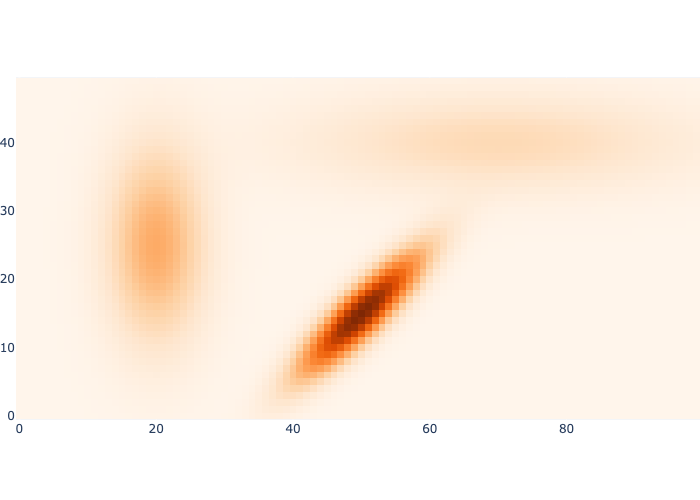

In [ ]:
means = [np.array([x, y]) for x, y in [(20, 25), (70, 40), (50, 15)]]
covariances = [np.diag([sx**2, sy**2]) for sx, sy in [(5, 10), (20, 5)]]
covariances.append(np.array([[40, 35], [35, 40]]))

image = np.zeros((50, 100))
for mean, cov in zip(means, covariances):
    image += gaussian(map_coords, mean, cov)
show_map(image/np.max(image))

## Base Map and Beacons

Defining the example warehouse map, and illustrating where sensors are.

In [ ]:
#| exporti

shelf_width = 9
shelf_gap = 8

spacing = shelf_width + shelf_gap
side = (100 - shelf_width*4 - shelf_gap*3) // 2

bottom = [[float(shelf_width)/2+side+i*spacing-0.5, 9.5] for i in range(4)]
top = [[float(shelf_width)/2+side+i*spacing-0.5, 39.5] for i in range(4)]

In [ ]:
#| export

base_map = np.zeros((50, 100))
for i in range(4):
    base_map[10:40, side+i*spacing:side+shelf_width+i*spacing] = 1

beacons = np.array(bottom + top)

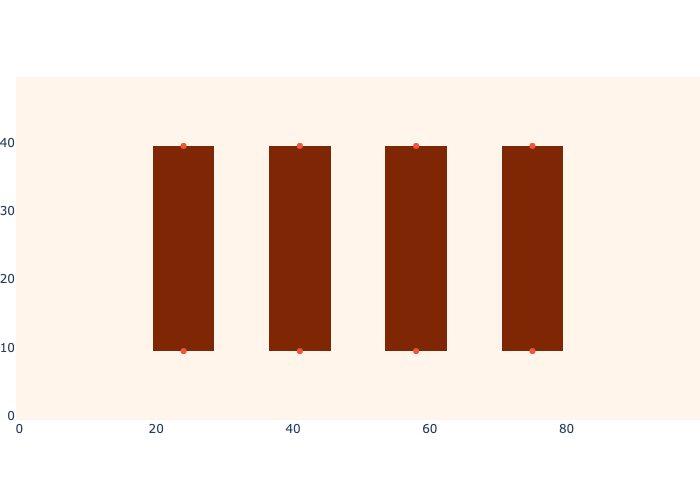

In [ ]:
show_map(base_map, beacons)

## Show Samples

Displaying samples on a map, for Monte Carlo Localization.


In [ ]:
from numpy.random import default_rng

In [ ]:
rng = default_rng()

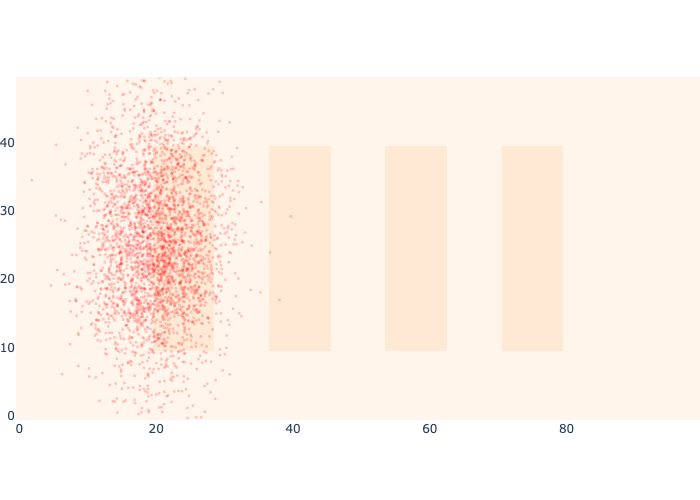

In [ ]:
S = 3000
prior = rng.multivariate_normal(means[0], covariances[0], size=S)
show_map(0.1*base_map, markers=prior,
         marker=dict(size=3, color="red", opacity=0.2))

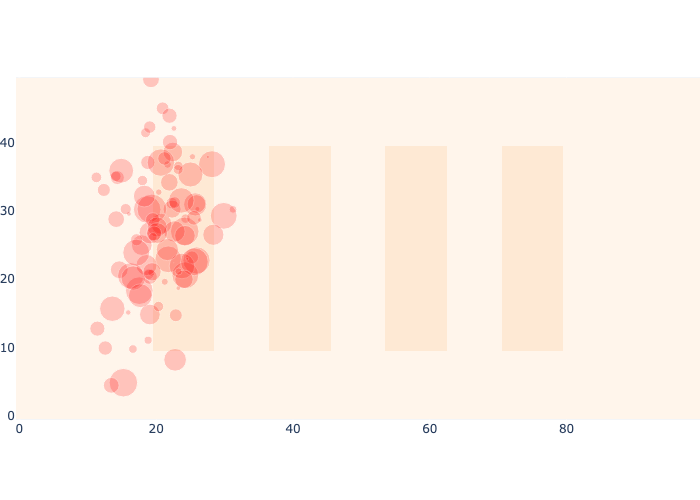

In [ ]:
T = 100
prior = rng.multivariate_normal(means[0], covariances[0], size=T)
weights = rng.uniform(0, 30, size=T)
show_map(0.1*base_map, markers=prior,
         marker=dict(size=weights, color="red", opacity=0.2))

## Proximity Sensor

Defining where a proximity sensor fires.

In [ ]:
#| exporti
proximity_range = 2  # what should be the proper proximity range ?

In [ ]:
#| export
proximity_map_on = np.zeros((50, 100))
for i in range(4):
    proximity_map_on[10-proximity_range:40+proximity_range, side+i *
                     spacing-proximity_range:side+shelf_width+i*spacing+proximity_range] = 1
proximity_map_on[0:proximity_range] = 1
proximity_map_on[-proximity_range:] = 1
proximity_map_on[:, -proximity_range:] = 1
proximity_map_on[:, 0:proximity_range:] = 1

for i in range(4):
    proximity_map_on[10:40, side+i*spacing:side+shelf_width+i*spacing] = 0

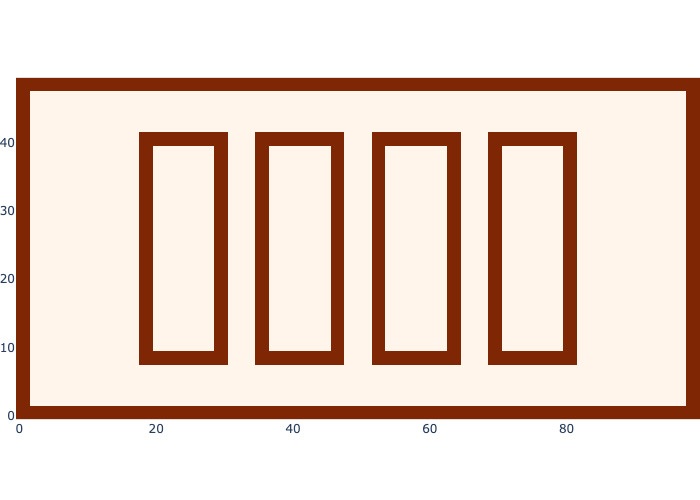

In [ ]:
show_map(proximity_map_on)

In [ ]:
#| export
proximity_map_off = np.full((50, 100), 1)
for i in range(4):
    proximity_map_off[10-proximity_range:40+proximity_range, side+i *
                      spacing-proximity_range:side+shelf_width+i*spacing+proximity_range] = 0

for i in range(4):
    proximity_map_off[10:40, side+i*spacing:side+shelf_width+i*spacing] = 0

proximity_map_off[0:proximity_range] = 0
proximity_map_off[-proximity_range:] = 0
proximity_map_off[:, -proximity_range:] = 0
proximity_map_off[:, 0:proximity_range:] = 0

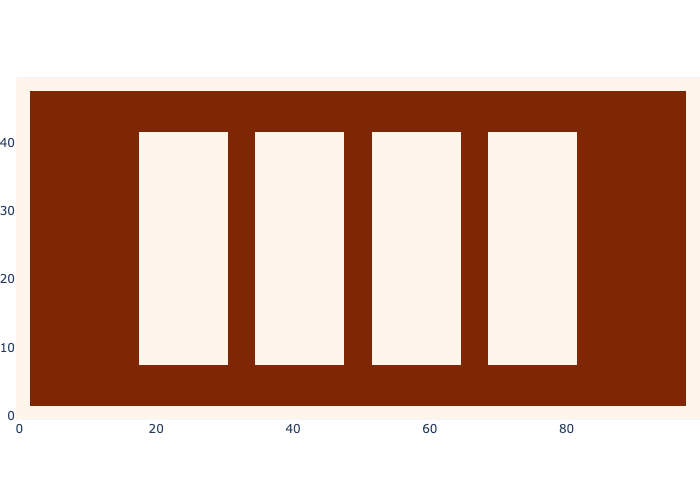

In [ ]:
show_map(proximity_map_off)

## Range Sensing:

Defining the "RFID" range sensing:

In [ ]:
#| export

def rfid_range(position, beacon, max_range=8):
    """Return range to given beacon."""
    range = np.linalg.norm(position-beacon)
    return float('inf') if range > max_range else range


def rfid_measurement(position, max_range=8):
    """Simulate RFID reader that returns nearest RFID range or (None,inf)."""
    ranges = [rfid_range(position, beacon, max_range) for beacon in beacons]
    range = min(ranges)
    return (np.argmin(ranges), range) if range <= max_range else (None, range)


def out_of_rfid_range(position, max_range=8):
    """Check if all beacons are out of range."""
    id, _ = rfid_measurement(position, max_range)
    return id == None

out_of_bound_map = np.array([[out_of_rfid_range(xy)
                            for xy in row] for row in map_coords])

Out of bounds map:


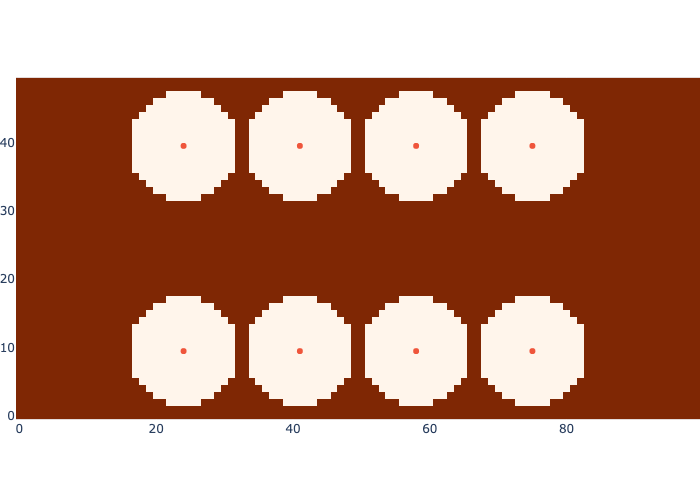

In [ ]:
show_map(out_of_bound_map, beacons)